In [2]:
# # Deep Learning
# 
# ## preprocessing training dataset

import os
from MLP import MLP
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

u'matplotlib inline'
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
u'load_ext autoreload'
u'autoreload 2'

u'autoreload 2'

In [3]:
def read_data():
    input_file_dir = "../datasets"
    train_file_name = "kddcup.data_10_percent.txt"
    test_file_name = "corrected.txt"
    header_file_name = "header.txt"
    train_files = os.path.join(input_file_dir, train_file_name)
    test_files = os.path.join(input_file_dir, test_file_name)
    header_files = os.path.join(input_file_dir, header_file_name)
    with open(header_files, 'r') as f:
        header = f.readline().strip().split(',')
    train_dataset = pd.read_csv(train_files)
    test_dataset = pd.read_csv(test_files)
    train_dataset.columns = header
    test_dataset.columns = header
    return train_dataset, test_dataset


def labels_map(label):
    label = str(label).split('.')[0]
    
    DOS = ['apache2', 'back', 'land', 'mailbomb', 'neptune', 'pod', 
                  'processtable', 'smurf', 'teardrop', 'udpstorm'] #DOS 10个
    PROBE = ['ipsweep', 'mscan', 'nmap', 'portsweep', 'saint', 'satan'] #PROBE
    U2R = ['buffer_overflow', 'httptunnel', 'loadmodule', 'perl', 'ps', 'rootkit', 'sqlattack', 'xterm'] #U2R
    R2L = ['ftp_write', 'guess_passwd', 'imap', 'multihop', 'named', 'phf', 
           'sendmail', 'snmpgetattack', 'snmpguess', 'spy', 'warezclient', 
           'warezmaster', 'worm', 'xlock', 'xsnoop']#R2L
        
    if label == 'normal':
        return 0
    if label in PROBE:
        return -1 
    if label in DOS:
        return DOS.index(label) + 1
    if label in U2R:
        return -1
    if label in R2L:
        return -1

def filter_labels(dataset):
    dataset['labels'] = dataset['labels'].apply(labels_map)
    #看看要保留哪些数据
    dataset = dataset[(dataset['labels']>-1)]
    return dataset

def split_valid_from_train(train_dataset, valid_size):
    # Method 1
    train_dataset, valid_dataset, _, _ = train_test_split(train_dataset, train_dataset['labels'], test_size=valid_size, random_state=None)
    
    # pandas中先重置index再打乱train. 否则只会调整各个行的顺序，而不会改变pandas的index
    # 重置
    train_dataset = train_dataset.reset_index(drop=True)
    # 打乱
    indexMask = np.arange(len(train_dataset))
    for i in xrange(10):
        np.random.shuffle(indexMask)
    train_dataset = train_dataset.iloc[indexMask]

    # Method 2
    #获取验证集
    # val_frac=0.25
    # valid_dataset_neg = train_dataset[(train_dataset['labels']==0)].sample(frac=val_frac)
    # valid_dataset_pos = train_dataset[(train_dataset['labels']==2)].sample(frac=val_frac)
    # valid_dataset = pd.concat([valid_dataset_neg, valid_dataset_pos], axis=0)
    # #train_dataset中分离出valid_dataset
    # train_dataset = train_dataset.select(lambda x: x not in valid_dataset.index, axis=0)
    return train_dataset, valid_dataset

def combine_train_valid_test(trainDF, validDF, testDF):
    all = pd.concat([trainDF, validDF, testDF], axis=0)
    return all, (trainDF.shape[0], validDF.shape[0], testDF.shape[0])

def process_data_features(all, handle_labels=True):
    if handle_labels:
        # 独热编码 labels
        labels_dummies = pd.get_dummies(all['labels'], prefix='label')
        all = pd.concat([all,labels_dummies], axis=1)
        all = all.drop(['labels'], axis=1)

    # 独热编码 protocol_type
    protocal_type_dummies = pd.get_dummies(all.protocol_type, prefix='protocol_type')
    all = pd.concat([all, protocal_type_dummies], axis=1)
    all = all.drop(['protocol_type'], axis=1)

    # 独热编码 flag
    flag_dummies = pd.get_dummies(all.flag, prefix='flag')
    all = pd.concat([all, flag_dummies], axis=1)
    all = all.drop(['flag'], axis=1)

    # 独热编码 Service 共有66个 暂时先去掉
    # all.service.value_counts()
    # service_dummies = pd.get_dummies(all.service, prefix='service')
    # all = pd.concat([all, service_dummies], axis=1)
    all = all.drop(['service'], axis=1)

    # 去中心化 src_bytes, dst_bytes
    all['src_bytes_norm'] = all.src_bytes - all.src_bytes.mean()
    all['dst_bytes_norm'] = all.dst_bytes - all.dst_bytes.mean()
    all = all.drop(['src_bytes'], axis=1)
    all = all.drop(['dst_bytes'], axis=1)

    return all.astype('float')

def recover_data_after_process_features(comb, num_comb, labels_list=[0,1,2,3]):
    #分离出Train Valid Test
    train_dataset_size, valid_dataset_size, test_dataset_size = num_comb
    sub_train_dataset = comb.iloc[:train_dataset_size, :].sample(frac=1)
    sub_valid_dataset = comb.iloc[train_dataset_size: train_dataset_size+valid_dataset_size, :].sample(frac=1)
    sub_test_dataset = comb.iloc[train_dataset_size+valid_dataset_size:, :].sample(frac=1)
    # 分离出 label
    total_labels = ['label_%d' % i for i in labels_list]
    print total_labels
    
    sub_train_labels = sub_train_dataset[total_labels]
    sub_valid_labels = sub_valid_dataset[total_labels]
    sub_test_labels = sub_test_dataset[total_labels]
    sub_train_dataset.drop(total_labels, axis=1, inplace=True)
    sub_valid_dataset.drop(total_labels, axis=1, inplace=True)
    sub_test_dataset.drop(total_labels, axis=1, inplace=True)
    data = {
        'X_train': sub_train_dataset.as_matrix(),
        'y_train': sub_train_labels.as_matrix(),
        'X_val': sub_valid_dataset.as_matrix(),
        'y_val': sub_valid_labels.as_matrix(),
        'X_test': sub_test_dataset.as_matrix(),
        'y_test': sub_test_labels.as_matrix()
    }
    for k, v in data.iteritems():
        print k, v.shape
    return data



def analysis_plot_loss_and_accuracy(model):
    print('Mean Accuracy( -top5 ) of train, valid, test: %.2f%%, %.2f%%, %.2f%%') % (100*np.mean(model.train_acc_history[-5:]),100*np.mean(model.val_acc_history[-5:]), 100*np.mean(model.test_acc_history[-5]))
    fig = plt.figure()
    ax = fig.add_subplot(2,1,1)
    ax.plot(range(len(model.loss_history)), model.loss_history, '-o')
    plt.plot()

    plt_len = len(model.train_acc_history)
    plt.subplot(2,1,2)
    plt.title('Accuracy')
    plt.plot(model.train_acc_history, '-o', label='train')
    plt.plot(model.test_acc_history, '-o', label='test')
    plt.plot(model.val_acc_history, '-o', label='valid')
    # plt.plot([90] * plt_len, 'k--')
    plt.xlabel('Iteration')
    plt.legend(loc='lower right')
    plt.gcf().set_size_inches(15,9)
    plt.show()

def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
            / predictions.shape[0])

def analysis_confusion_matrix(X,y, model, header, verbose=True):
    y_pred = model.predict(X)
    m = len(header)
    y_true = np.argmax(y, axis=1)
    y_predIdx = np.argmax(y_pred, axis=1)
    mat = np.mat(np.zeros((m,m)))
    for real, pred in zip(y_true,y_predIdx):
        mat[real,pred] = mat[real,pred] + 1
    confMatrix = pd.DataFrame(data=mat, index= header, columns=header, dtype=int)
    if verbose:
        print ('Accuracy: %.2f%%' % accuracy(y_pred, y))
#         print confMatrix
    return confMatrix

def analysis_precision_recall(confMat):
    """
    recall: 是相对于原始样本的, 检测率
    precision: 是相对于预测结果的, 精确率
    """
    m = len(confMat)
    recall = np.diag(confMat) / np.sum(confMat, axis=1) #检测率
    precission = np.diag(confMat) / np.sum(confMat, axis=0) #精确率
    ret = pd.concat([recall, precission], axis=1)
    ret.columns=['recall', 'precission']
    return ret

In [4]:
# Prepare Data
trainDF, testDF = read_data()

In [5]:
trainDF = filter_labels(trainDF)
testDF = filter_labels(testDF)
testDF = testDF[(testDF['labels'] != 1) & (testDF['labels'] != 4) & (testDF['labels']!=7 ) & (testDF['labels']<10)]
trainDF, validDF = split_valid_from_train(trainDF, 0.25)

In [6]:
print Counter(trainDF['flag'])
print Counter(testDF['flag'])
print Counter(trainDF['protocol_type'])
print Counter(testDF['protocol_type'])

Counter({'SF': 281802, 'S0': 65148, 'REJ': 19055, 'RSTO': 395, 'RSTR': 90, 'S1': 45, 'S2': 11, 'S3': 5})
Counter({'SF': 225663, 'REJ': 39640, 'S0': 17444, 'RSTO': 976, 'RSTR': 129, 'S1': 18, 'S2': 15, 'S3': 4, 'RSTOS0': 1})
Counter({'icmp': 211929, 'tcp': 139419, 'udp': 15203})
Counter({'icmp': 164556, 'tcp': 103226, 'udp': 16108})


In [7]:
# from sklearn.preprocessing import LabelEncoder
# protocal_labelencoder = LabelEncoder()
# flag_labelencoder = LabelEncoder()

# testDF['protocol_type'] = protocal_labelencoder.fit_transform(testDF['protocol_type'])
# testDF['flag'] = flag_labelencoder.fit_transform(testDF['flag']).astype(int)
# testDF.drop('service', axis=1, inplace=True)

# trainDF['protocol_type'] = protocal_labelencoder.transform(testDF['protocol_type'])
# trainDF['flag'] = flag_labelencoder.transform(trainDF['flag']).astype(int)
# trainDF.drop('service',axis=1, inplace=True)

In [8]:
mask_8 = trainDF['labels'] == 8
mask_5 = trainDF['labels'] == 5
mask_0 = trainDF['labels'] == 0
trainDF = pd.concat([trainDF[mask_8].sample(n=10000), 
                     trainDF[mask_5].sample(n=10000),
                     trainDF[mask_0].sample(n=10000),
                    trainDF[trainDF['labels'].isin([2,9,6,3])]], axis=0)

print Counter(trainDF['labels'])

Counter({0: 10000, 5: 10000, 8: 10000, 2: 1629, 9: 762, 6: 196, 3: 14})


In [9]:
count = Counter(trainDF['labels'])
expect_sample_size = 5000
for label in [2,9,6,3]:
    copy_cnt = expect_sample_size // count[label]
    copy_part = trainDF[trainDF['labels'] == label]
    for i in xrange(copy_cnt):
        trainDF = pd.concat([trainDF, copy_part], axis=0)
Counter(trainDF['labels'])

Counter({0: 10000, 2: 6516, 3: 5012, 5: 10000, 6: 5096, 8: 10000, 9: 5334})

In [10]:
combine, num_combine = combine_train_valid_test(trainDF, validDF, testDF)

In [11]:
combine = process_data_features(combine, True)

In [12]:
data = recover_data_after_process_features(combine, num_combine, [0,2,3,5,6,8,9])

['label_0', 'label_2', 'label_3', 'label_5', 'label_6', 'label_8', 'label_9']
X_val (122184, 51)
X_train (51958, 51)
X_test (283890, 51)
y_val (122184, 7)
y_train (51958, 7)
y_test (283890, 7)


In [18]:
# """过采样"""
# normal, back, land, neptune, pod, smurf, teardrop
# DOS = np.array(DOS)[[0,2,3,5,6,8,9]].tolist()
# sm = SMOTE(random_state=12)
# X_train, y_train = sm.fit_sample(trainDF.drop('labels',axis=1), trainDF['labels'])
# trainDF = pd.DataFrame(data=X_train, columns=trainDF.drop('labels',axis=1).columns)
# y_train = pd.DataFrame(data=y_train, columns=['lables'])
# trainDF = pd.concat([trainDF, y_train], axis=1)

In [14]:
# Model
input_dim = data['X_train'].shape[1]
output_dim = data['y_train'].shape[1]
model = MLP(data, input_dim, [512],output_dim,
                learning_rate=1e-4, #1e-6
                dropout_prob=0.0,
                l2_strength=0.1,
                batch_size=200,
                num_epochs=10,
                print_every=200,
                verbose=True)

model.train()

(Iteration 0 / 2590) train acc: 28.00%; val_acc: 23.65%; test_acc: 44.55%
(Iteration 200 / 2590) train acc: 83.50%; val_acc: 99.03%; test_acc: 99.07%
(Iteration 400 / 2590) train acc: 96.00%; val_acc: 93.68%; test_acc: 93.88%
(Iteration 600 / 2590) train acc: 97.50%; val_acc: 98.46%; test_acc: 98.76%
(Iteration 800 / 2590) train acc: 78.50%; val_acc: 82.57%; test_acc: 77.87%
(Iteration 1000 / 2590) train acc: 86.50%; val_acc: 98.65%; test_acc: 99.11%
(Iteration 1200 / 2590) train acc: 89.50%; val_acc: 98.98%; test_acc: 96.26%
(Iteration 1400 / 2590) train acc: 97.00%; val_acc: 98.77%; test_acc: 99.04%
(Iteration 1600 / 2590) train acc: 94.00%; val_acc: 93.26%; test_acc: 92.49%
(Iteration 1800 / 2590) train acc: 91.00%; val_acc: 99.12%; test_acc: 98.66%
(Iteration 2000 / 2590) train acc: 97.00%; val_acc: 99.29%; test_acc: 99.20%
(Iteration 2200 / 2590) train acc: 100.00%; val_acc: 98.34%; test_acc: 97.90%
(Iteration 2400 / 2590) train acc: 98.00%; val_acc: 98.42%; test_acc: 98.30%


In [15]:
from sklearn.metrics import classification_report
DOS = ['normal', 'apache2', 'back', 'land', 'mailbomb', 'neptune', 'pod', 
                  'processtable', 'smurf', 'teardrop', 'udpstorm'] #DOS 10个
DOS = np.array(DOS)[[0,2,3,5,6,8,9]].tolist()

y_pred = model.predict(data['X_test'])
print classification_report(np.argmax(data['y_test'],axis=1), np.argmax(y_pred, axis=1), target_names=DOS)
print 'Accuracy %.2f' % accuracy(y_pred, data['y_test'])

             precision    recall  f1-score   support

     normal       1.00      0.93      0.96     60592
       back       0.96      1.00      0.98      1098
       land       0.02      0.78      0.03         9
    neptune       1.00      0.99      0.99     58001
        pod       0.16      0.91      0.27        87
      smurf       1.00      1.00      1.00    164091
   teardrop       0.00      0.75      0.00        12

avg / total       1.00      0.98      0.99    283890

Accuracy 98.25


In [16]:
# Analysis
DOS = ['normal', 'apache2', 'back', 'land', 'mailbomb', 'neptune', 'pod', 
                  'processtable', 'smurf', 'teardrop', 'udpstorm'] #DOS 10个
DOS = np.array(DOS)[[0,2,3,5,6,8,9]].tolist()
ATTACK = ['normal', 'probe', 'dos', 'u2r', 'r2l']

confMat = analysis_confusion_matrix(data['X_test'],data['y_test'], model, DOS)
print confMat

analysis_precision_recall(confMat)

Accuracy: 98.25%
          normal  back  land  neptune  pod   smurf  teardrop
normal     56339    44   432      210  425       0      3142
back           4  1094     0        0    0       0         0
land           0     0     7        0    0       0         2
neptune        0     0     7    57519    0       0       475
pod            6     0     0        0   79       0         2
smurf        163     0     0        0    0  163879        49
teardrop       0     0     3        0    0       0         9


,recall,precission
normal,0.929809,0.996939
back,0.996357,0.961336
land,0.777778,0.015590
neptune,0.991690,0.996362
pod,0.908046,0.156746
smurf,0.998708,1.000000
teardrop,0.750000,0.002446


Mean Accuracy( -top5 ) of train, valid, test: 96.00%, 97.69%, 92.49%


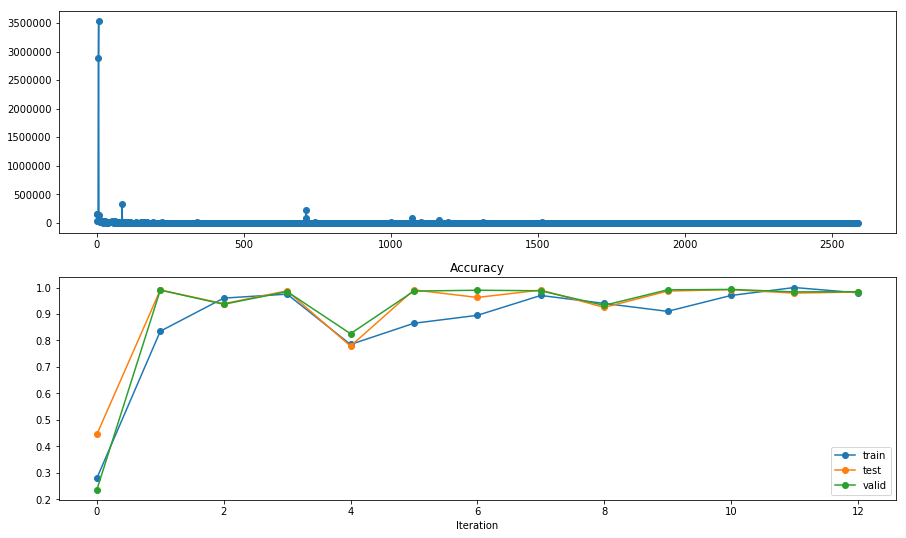

In [17]:
analysis_plot_loss_and_accuracy(model)